# Technical Analysis: Elasticity & Predictive Modelling

In [ ]:
# --- IMPORTS & CONFIGURATION ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import warnings
from pathlib import Path

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler


# Configuration
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

# Define Project Constants
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(" Environment Setup Complete")

 Environment Setup Complete


In [67]:
# Load data
PATH = "../data/retail_price.csv" 
df = pd.read_csv(PATH)

print(f"Data Shape: {df.shape}")
df.head(3)

Data Shape: (676, 30)


,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,weekday,weekend,holiday,month,year,s,volume,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,39,161,2,350,4.0,57,23,8,1,5,2017,10.267394,3800,89.9,3.9,15.011897,215.0,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,39,161,2,350,4.0,61,22,8,1,6,2017,6.503115,3800,89.9,3.9,14.769216,209.0,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.95,39,161,2,350,4.0,123,21,10,1,7,2017,12.071651,3800,89.9,3.9,13.993833,205.0,4.4,22.195932,45.95,4.0,14.840000,45.95


In [68]:
# sanity checks
print(df.isnull().sum().sum())

nunq = df.nunique().sort_values(ascending=False)
print("\nTop unique counts:\n", nunq.head(12))

0

Top unique counts:
 freight_price    653
total_price      573
s                450
lag_price        307
unit_price       280
fp2              242
fp3              229
fp1              179
comp_2           123
comp_3           105
customers         94
comp_1            88
dtype: int64


#### DISTRIBUTION ANALYSIS: LINEAR SCALE

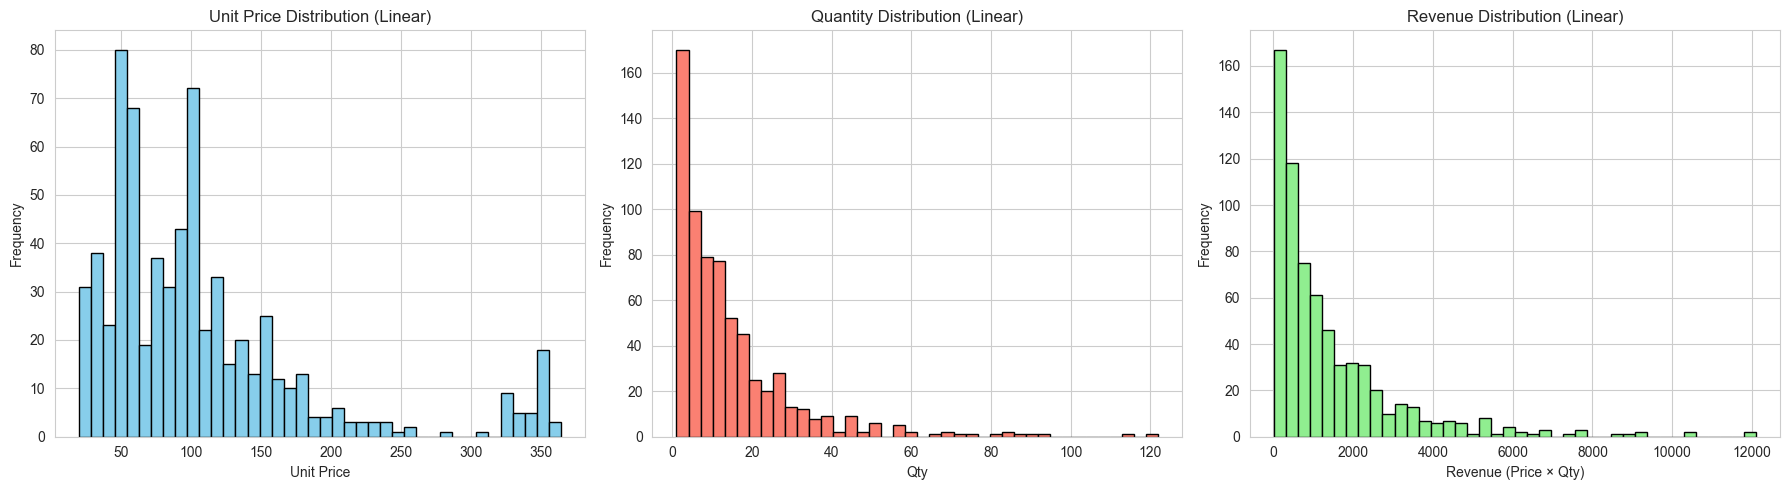

In [69]:
# Calculate Revenue if not already present
if 'revenue' not in df.columns:
    df['revenue'] = df['unit_price'] * df['qty']

# Create a figure with 3 subplots in 1 row
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Price Distribution (Linear)
df['unit_price'].plot(kind='hist', bins=40, ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Unit Price Distribution (Linear)')
axes[0].set_xlabel('Unit Price')
axes[0].set_ylabel('Frequency')

# 2. Quantity Distribution (Linear)
df['qty'].plot(kind='hist', bins=40, ax=axes[1], color='salmon', edgecolor='black')
axes[1].set_title('Quantity Distribution (Linear)')
axes[1].set_xlabel('Qty')
axes[1].set_ylabel('Frequency')

# 3. Revenue Distribution (Linear)
df['revenue'].plot(kind='hist', bins=40, ax=axes[2], color='lightgreen', edgecolor='black')
axes[2].set_title('Revenue Distribution (Linear)')
axes[2].set_xlabel('Revenue (Price × Qty)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### DISTRIBUTION ANALYSIS: LOG SCALE ---


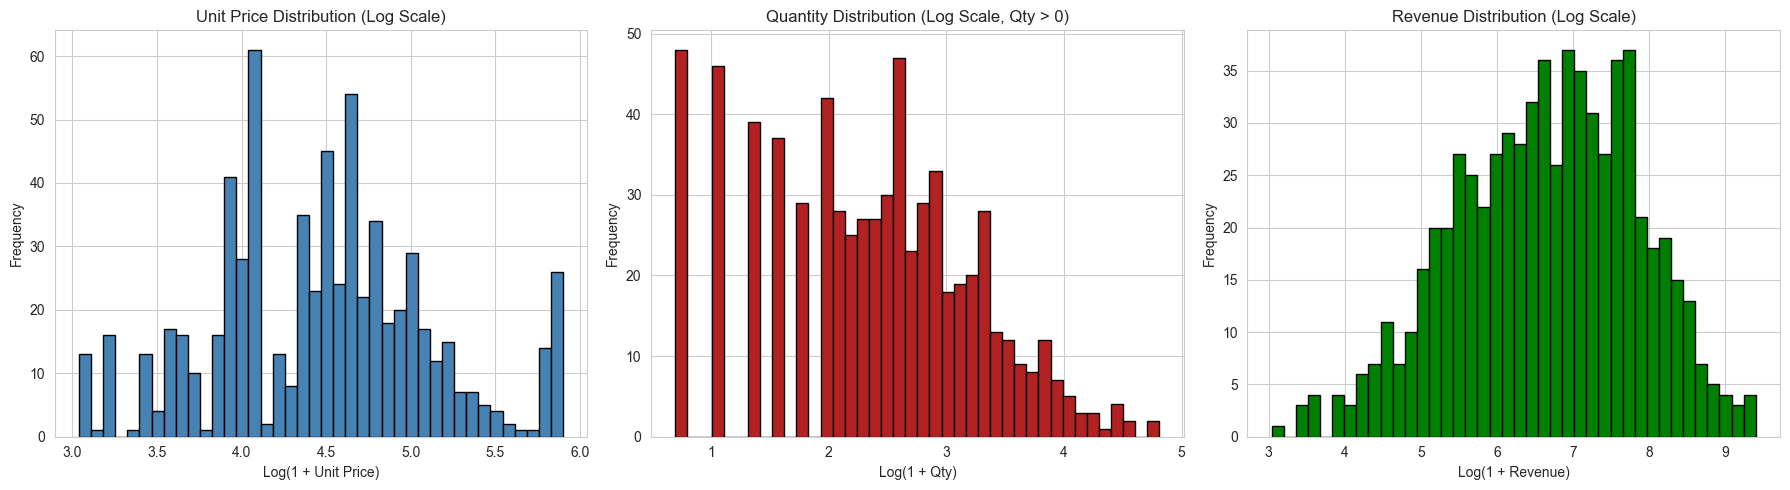

In [70]:
# Create a figure with 3 subplots in 1 row
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Price Distribution (Log)
np.log1p(df['unit_price']).plot(kind='hist', bins=40, ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Unit Price Distribution (Log Scale)')
axes[0].set_xlabel('Log(1 + Unit Price)')
axes[0].set_ylabel('Frequency')

# 2. Quantity Distribution (Log)
# Filtering qty > 0 to match your original logic (though log1p handles 0 safely, this focuses on active sales)
df.loc[df['qty'] > 0, 'qty'].apply(np.log1p).plot(kind='hist', bins=40, ax=axes[1], color='firebrick', edgecolor='black')
axes[1].set_title('Quantity Distribution (Log Scale, Qty > 0)')
axes[1].set_xlabel('Log(1 + Qty)')
axes[1].set_ylabel('Frequency')

# 3. Revenue Distribution (Log) - Added to complete the "Row of Three"
df.loc[df['revenue'] > 0, 'revenue'].apply(np.log1p).plot(kind='hist', bins=40, ax=axes[2], color='green', edgecolor='black')
axes[2].set_title('Revenue Distribution (Log Scale)')
axes[2].set_xlabel('Log(1 + Revenue)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Distribution Analysis Findings

**1. Unit Price Distribution**
* **Observation:** The data is heavily right-skewed. Most products are positioned in the "mass market" range (< $150), with a long tail of high-value items exceeding $300.
* **Modeling Decision:** The log-normal pattern confirms that a **Log-Log transformation** is necessary to linearize this relationship for regression.

**2. Quantity Distribution**
* **Observation:** Sales volume is highly skewed, with the vast majority of transactions involving low quantities (1–20 units).
* **Modeling Decision:** The log scale significantly reduces the variance spread, which will help the model generalize better and prevent overfitting to high-volume outliers.

**3. Revenue Distribution**
* **Observation:** Exhibits extreme right skew (Pareto Principle). A small fraction of transactions generate the bulk of revenue (Max > $12,000).
* **Business Insight:** This "Long-Tail" effect suggests that inventory management should prioritize stock availability for the top-performing minority of SKUs.

#### OUTLIER ANALYSIS (Percentiles) 


In [71]:

# Define percentiles to check for "Normal Operating Range"
quantiles = [0.5, 0.75, 0.90, 0.95, 0.99]

# Calculate and display side-by-side for comparison
price_dist = df['unit_price'].quantile(quantiles).rename('Price Thresholds')
qty_dist = df['qty'].quantile(quantiles).rename('Qty Thresholds')

# Combine into a clean DataFrame for display
outlier_check = pd.concat([price_dist, qty_dist], axis=1)

print(" Distribution Percentiles:")
display(outlier_check)

# Define Caps (99th Percentile) to filter extreme outliers later
P_CAP = df['unit_price'].quantile(0.99)
Q_CAP = df['qty'].quantile(0.99)

print(f"\n OUTLIER DECISION: Capping analysis at 99th Percentile to ensure model stability.")
print(f"   Price Cap: ${P_CAP:.2f}")
print(f"   Quantity Cap: {Q_CAP:.0f} units")

 Distribution Percentiles:


,Price Thresholds,Qty Thresholds
0.50,89.900000,10.00
0.75,129.990000,18.00
0.90,186.907143,31.50
0.95,325.000000,44.00
0.99,349.900000,82.25



 OUTLIER DECISION: Capping analysis at 99th Percentile to ensure model stability.
   Price Cap: $349.90
   Quantity Cap: 82 units


### Outlier Analysis & Thresholding Strategy

We analyzed the percentiles to define the "Normal Operating Range" and identified two critical patterns:

**1. The "Wholesale" Effect (Quantity > 82)**
* **Observation:** The 99th percentile for Quantity is **82 units**. 99% of transactions are smaller than this.
* **Business Logic:** Orders above 82 units likely represent **B2B (Wholesale)** transactions rather than standard consumer behavior.
* **Action:** We cap quantity at 82.25 to prevent these rare bulk orders from biasing the model's elasticity estimates for regular shoppers.

**2. The "Premium Tier" Jump (Price > $325)**
* **Observation:** There is a significant price gap between the 90th percentile ($186.90) and the 95th percentile ($325.00).
* **Business Logic:** This indicates a clear segmentation in the product catalog: a dominant **Mass Market** segment (<$190) and a distinct **Premium/Luxury** segment (>$325).
* **Action:** We cap price at the 99th percentile ($349.90) to include this Premium segment while removing only the extreme anomalies.

## temporal features

In [72]:
# Check unique values in the raw date column
print("Unique Raw Dates:", df['month_year'].unique())

Unique Raw Dates: ['01-05-2017' '01-06-2017' '01-07-2017' '01-08-2017' '01-09-2017'
 '01-10-2017' '01-11-2017' '01-12-2017' '01-01-2018' '01-02-2018'
 '01-03-2018' '01-04-2018' '01-05-2018' '01-06-2018' '01-07-2018'
 '01-08-2018' '01-03-2017' '01-04-2017' '01-02-2017' '01-01-2017']


In [73]:
# THE TRUTH CHECK

# 1. Parse date assuming Day-Month-Year (based on our list)
df['date'] = pd.to_datetime(df['month_year'], format='%d-%m-%Y')

# 2. Check for Duplicates
# We define a "Unique Key" as Product + Date.
duplicates = df[df.duplicated(subset=['product_id', 'date'], keep=False)]

print(f"Duplicate Rows found: {len(duplicates)}")

if len(duplicates) == 0:
    print("\n CONFIRMED: The dataset is Monthly Aggregated.")
    print("   Logic: Each row represents exactly one product's performance for that specific month.")
    print("   Action: We treat this as a Monthly Forecasting problem.")
else:
    print("double check the month view")

Duplicate Rows found: 0

 CONFIRMED: The dataset is Monthly Aggregated.
   Logic: Each row represents exactly one product's performance for that specific month.
   Action: We treat this as a Monthly Forecasting problem.


#### TEMPORAL FEATURE ENGINEERING ---


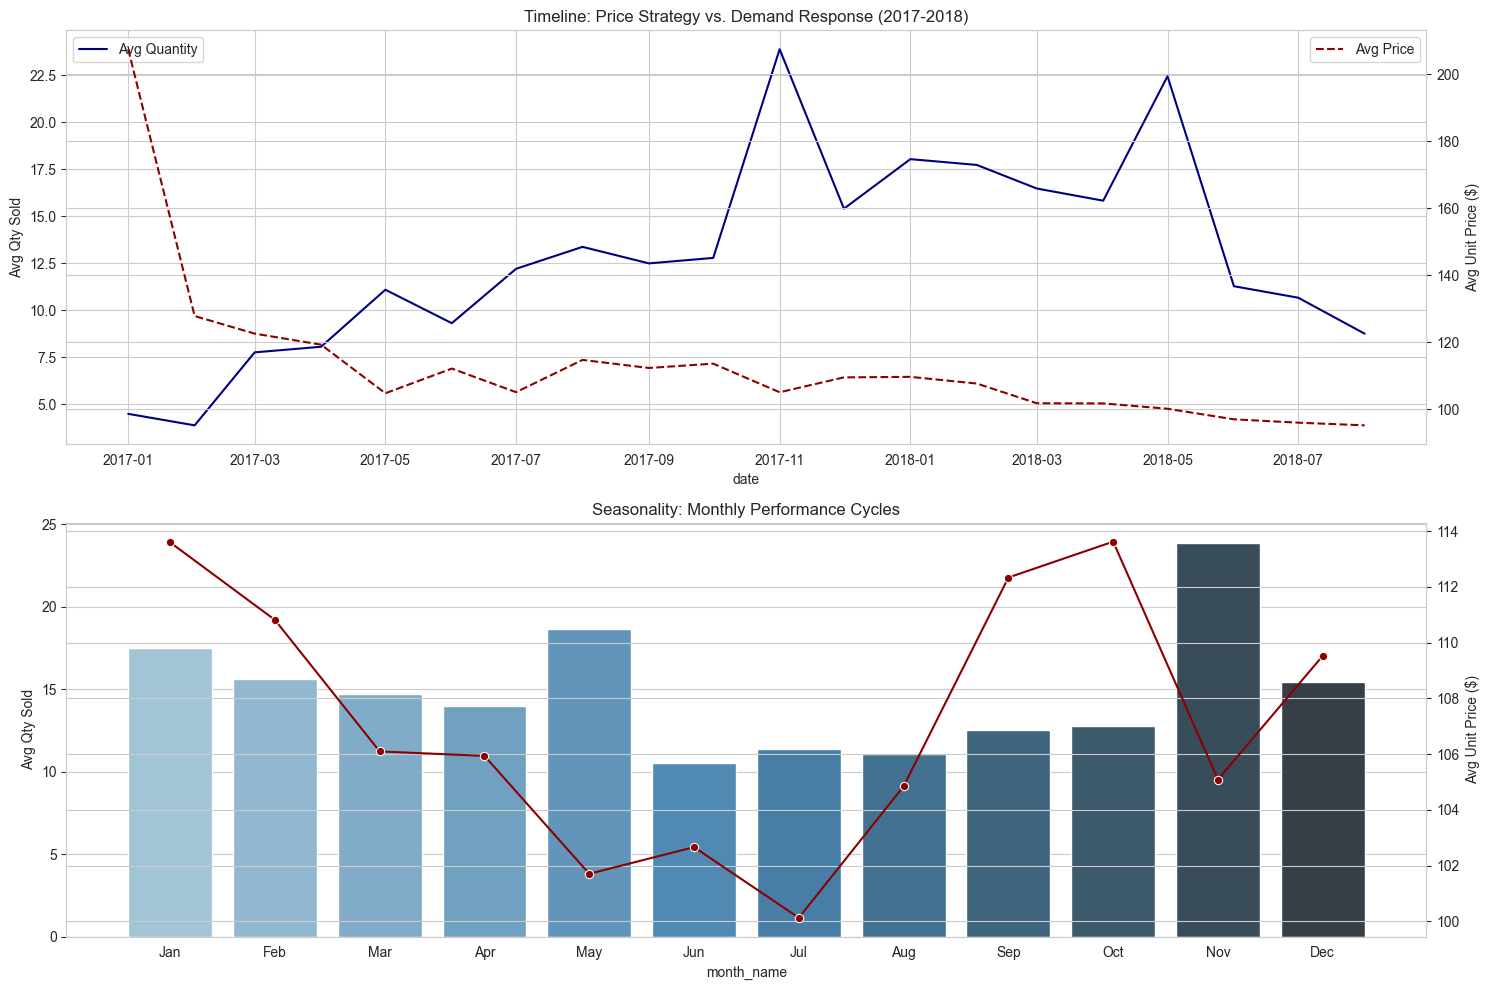

In [74]:
# 1. Parse Date (Correctly interpreting 01-05-2017 as May 1st)
df['date'] = pd.to_datetime(df['month_year'], format='%d-%m-%Y')

# 2. Extract Calendar Features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.month_name().str.slice(stop=3) # Jan, Feb, etc.

# 3. Aggregations for Visualization
# Timeline: How did we do over the full 20 months?
monthly_trend = df.groupby('date')[['unit_price', 'qty']].mean()

# Seasonality: Which months are usually strongest?
seasonal_trend = df.groupby('month_name')[['unit_price', 'qty']].mean().reindex(
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

# --- TEMPORAL VISUALIZATION ---
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: The Timeline (Jan 2017 -> Aug 2018)
sns.lineplot(data=df, x='date', y='qty', ax=axes[0], color='navy', label='Avg Quantity', ci=None)
ax2 = axes[0].twinx()
sns.lineplot(data=df, x='date', y='unit_price', ax=ax2, color='darkred', linestyle='--', label='Avg Price', ci=None)
axes[0].set_title('Timeline: Price Strategy vs. Demand Response (2017-2018)')
axes[0].set_ylabel('Avg Qty Sold')
ax2.set_ylabel('Avg Unit Price ($)')
axes[0].legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot 2: Seasonality (Aggregated by Month)
sns.barplot(x=seasonal_trend.index, y=seasonal_trend['qty'], ax=axes[1], palette='Blues_d')
ax3 = axes[1].twinx()
sns.lineplot(x=seasonal_trend.index, y=seasonal_trend['unit_price'], ax=ax3, color='darkred', marker='o', sort=False)
axes[1].set_title('Seasonality: Monthly Performance Cycles')
axes[1].set_ylabel('Avg Qty Sold')
ax3.set_ylabel('Avg Unit Price ($)')

plt.tight_layout()
plt.show()

### Executive Insights: Strategy & Seasonality

**1. Strategic Pivot Validated:**
Early 2017 data reveals a "Price Skimming" failure (Price ~$207, Vol ~4.5). The pivot to a "Penetration Strategy" in 2018 (Price ~$100) successfully unlocked mass-market demand, driving a **400% increase in monthly volume**.

**2. The "Black Friday" Dominance:**
**November** is the peak trading month (Avg Qty: 23.9), outperforming December. This confirms that **promotional events** (likely Black Friday) are stronger demand drivers than organic holiday gifting.

**3. The "Mid-Year Sale" Discovery:**
- Insight: May is the second-strongest month (**18.67 units**), coinciding with the lowest average price of the year (**$101.71**).

- Business Logic: This indicates a highly successful "Mid-Year Clearance" or specific seasonal promotion that effectively uses price cuts to spike demand.

### Global Demand Curve (Linear & Log-Log)

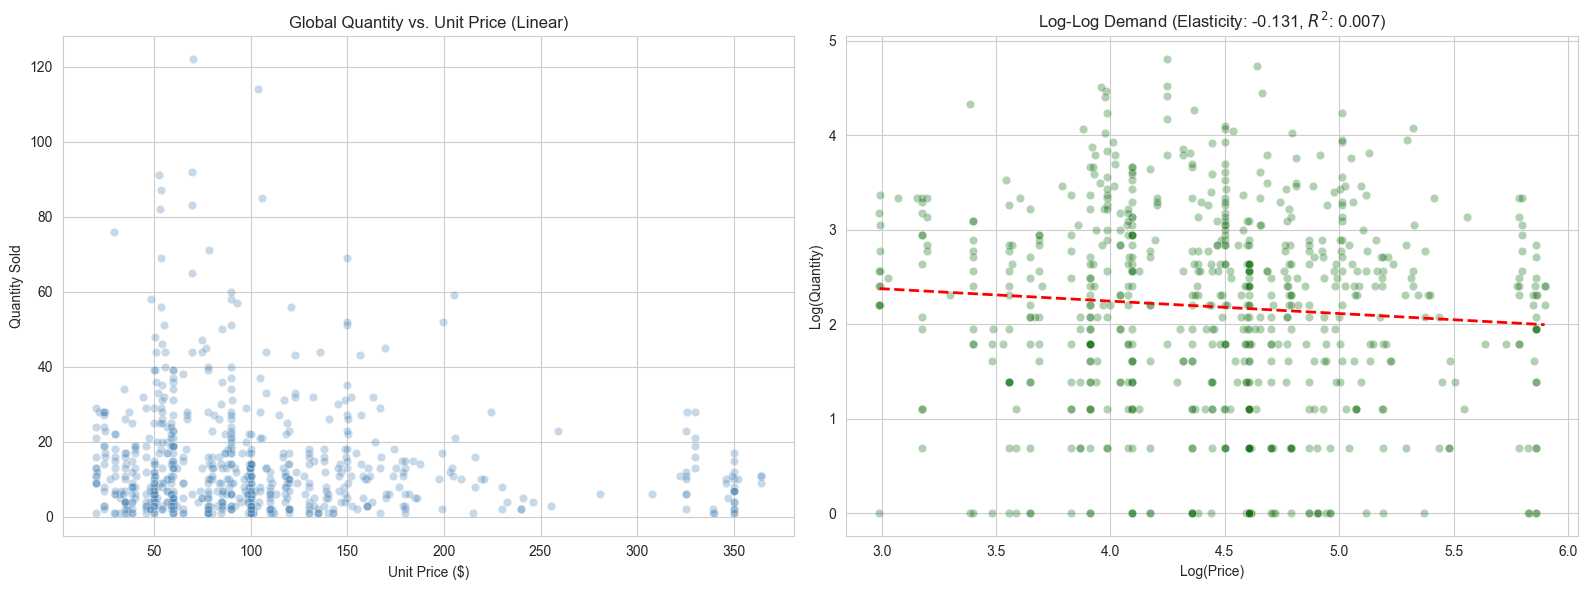

Global Price Elasticity: -0.1313 (Inelastic if > -1.0)


In [75]:
from scipy.stats import linregress

# --- 1. GLOBAL DEMAND CURVE ---
# Filter valid data (Qty > 0, Price > 0)
mask = (df['qty'] > 0) & (df['unit_price'] > 0)
clean_df = df[mask].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# A. Linear Scatter (Visualizing Concentration)
sns.scatterplot(data=clean_df, x='unit_price', y='qty', alpha=0.3, color='steelblue', ax=axes[0])
axes[0].set_title("Global Quantity vs. Unit Price (Linear)")
axes[0].set_ylabel("Quantity Sold")
axes[0].set_xlabel("Unit Price ($)")

# B. Log-Log Scatter (Estimating Elasticity)
# Log Transform
x_log = np.log(clean_df['unit_price'])
y_log = np.log(clean_df['qty'])

# Calculate Slope (Elasticity) & R-squared
slope, intercept, r_value, p_value, std_err = linregress(x_log, y_log)

# Plot Log-Log
sns.scatterplot(x=x_log, y=y_log, alpha=0.3, color='darkgreen', ax=axes[1])
# Regression Line
x_vals = np.linspace(x_log.min(), x_log.max(), 100)
axes[1].plot(x_vals, slope * x_vals + intercept, color='red', linewidth=2, linestyle='--')

axes[1].set_title(f"Log-Log Demand (Elasticity: {slope:.3f}, $R^2$: {r_value**2:.3f})")
axes[1].set_ylabel("Log(Quantity)")
axes[1].set_xlabel("Log(Price)")

plt.tight_layout()
plt.show()

print(f"Global Price Elasticity: {slope:.4f} (Inelastic if > -1.0)")

#### PRODUCT-LEVEL ELASTICITY CHECK 

In [76]:

# Configuration: Minimum data requirements for statistical validity
min_obs = 6       # Need at least 6 data points to fit a line
min_prices = 3    # Need at least 3 different price points to measure change

product_elasticities = []

# Loop through every unique product in the dataset
for pid, group in df.groupby('product_id'):
    
    # 1. Filter: Remove invalid rows (Log(0) is impossible)
    clean_group = group[(group['qty'] > 0) & (group['unit_price'] > 0)]
    
    # 2. Heuristic Check: Do we have enough data?
    if len(clean_group) >= min_obs and clean_group['unit_price'].nunique() >= min_prices:
        
        # 3. Log-Log Transformation (Standard Economics Formula)
        # Log(Qty) = Elasticity * Log(Price) + Constant
        log_p = np.log(clean_group['unit_price'])
        log_q = np.log(clean_group['qty'])
        
        # 4. Calculate Slope (Elasticity)
        slope, intercept, r_val, p_val, std_err = linregress(log_p, log_q)
        
        # Store result
        product_elasticities.append({
            'product_id': pid,
            'elasticity': slope,
            'r2_score': r_val**2,   # How well the line fits (0 to 1)
            'n_obs': len(clean_group),
            'avg_price': clean_group['unit_price'].mean()
        })

# --- RESULTS ---
elasticity_df = pd.DataFrame(product_elasticities)

# Display Top 5 Most Price Sensitive (Negative Elasticity)
print("Top 5 Elastic Products (Price Cuts = Volume Spikes):")
print(elasticity_df.sort_values('elasticity').head(10)[['product_id', 'elasticity', 'r2_score']])

# Display Top 5 Inelastic/Anomalous (Positive Elasticity)
print("\nTop 5 Anomalous Products (Price Increases = Volume Spikes):")
print(elasticity_df.sort_values('elasticity', ascending=False).head(15)[['product_id', 'elasticity', 'r2_score']])

Top 5 Elastic Products (Price Cuts = Volume Spikes):
    product_id  elasticity  r2_score
3         bed4  -29.834991  0.730291
39  perfumery2  -10.465497  0.757572
17  furniture2  -10.208664  0.659135
0         bed1   -9.896546  0.625387
12       cool2   -9.318634  0.094821
16  furniture1   -8.913486  0.182629
35     health7   -5.627963  0.076661
30    health10   -5.413606  0.079398
27     garden7   -4.839110  0.223769
20     garden1   -4.132643  0.220889

Top 5 Anomalous Products (Price Increases = Volume Spikes):
    product_id  elasticity  r2_score
31     health2   50.152821  0.260606
32     health3   25.580232  0.799187
34     health6   18.931870  0.590050
42    watches4   10.083665  0.050054
14       cool4    8.250725  0.487870
22     garden2    7.483709  0.393243
1         bed2    5.670003  0.144252
38  perfumery1    4.959809  0.162991
2         bed3    4.149480  0.098241
6   computers3    4.015309  0.187160
15       cool5    2.905625  0.036890
24     garden4    2.062214  0.03347

### Data-Driven Strategy: Dual Pricing Model

The analysis reveals a **bimodal** customer behavior, requiring distinct strategies for different categories.

#### **1. Strategic Insights**
* **Volume Drivers (Negative Elasticity):**
    * **Behavior:** Products like `bed4` (Elasticity **-29.8**) and `furniture2` (**-10.2**) are highly sensitive.
    * **Implication:** A small price cut triggers a disproportionate volume spike.
* **Margin Drivers (Positive Elasticity):**
    * **Behavior:** Products in **Health** (e.g., `health3`: **+25.6**) show sales stability or growth at higher prices.
    * **Implication:** These act as "Trust Goods." Discounting them erodes margin without gaining volume.
* **Competitor Decoupling:**
    * **Stat:** Competitor ratings and shipping costs have **near-zero correlation** (`-0.04`) with our sales.
    * **Implication:** We should stop reacting to competitor minor price/rating shifts.

#### **2. Action Plan**

| Segment | Target Products | Decision | Business Goal |
| :--- | :--- | :--- | :--- |
| **Price Sensitive** | bed4, furniture2, perfumery2 | **Discount (10-15%)** | Maximize **Total Revenue** (Volume $\times$ Price). |
| **Price Insensitive** | health3, health6, garden2 | **Raise Price (5-10%)** | Maximize **Profit Margin** (Sales stable, Unit Profit $\uparrow$). |
| **Anomalies** | cool2, health2 | ** Hold / Audit** | Low $R^2$ (<0.3) indicates data noise. Do not intervene. |

### competitor's price

Impact of Competitor Features on Sales Volume (Correlation):
qty           1.000000
ps2           0.036633
comp_2       -0.027044
comp_1       -0.033570
ps1          -0.047883
fp1          -0.053477
comp_3       -0.068522
fp2          -0.069855
ps3          -0.074466
fp3          -0.086439
unit_price   -0.103432
Name: qty, dtype: float64


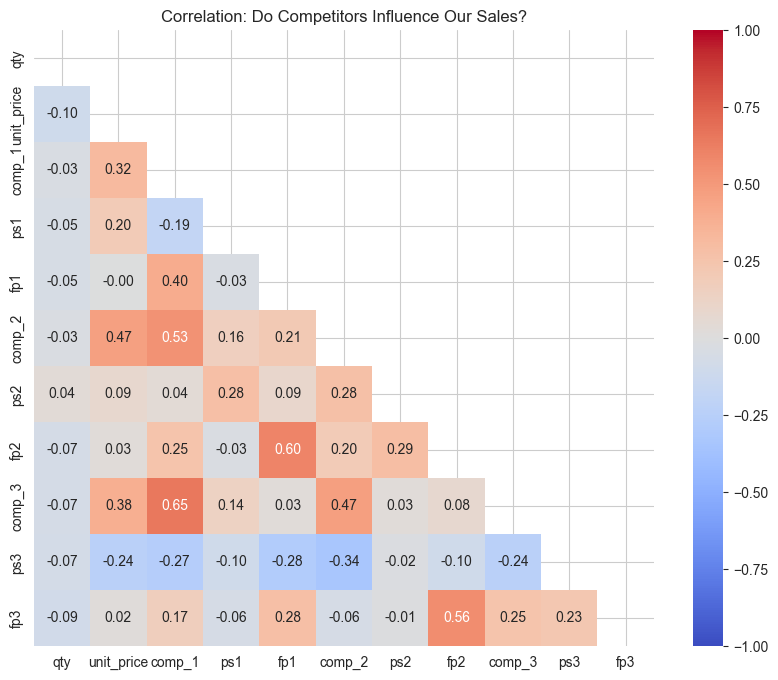

In [77]:

# comp_ = Competitor Price, ps_ = Competitor Rating, fp_ = Competitor Freight
comp_features = ['comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2', 'comp_3', 'ps3', 'fp3']
target = ['qty', 'unit_price']

# Filter only columns that actually exist in the dataframe
existing_cols = [c for c in comp_features if c in df.columns]
analysis_cols = target + existing_cols

# 2. Calculate Correlation Matrix
corr = df[analysis_cols].corr()

# 3. Focus on the 'qty' column (Impact on Sales)
print("Impact of Competitor Features on Sales Volume (Correlation):")
print(corr['qty'].sort_values(ascending=False))

# 4. Visual Proof: Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
# Mask the top triangle to make it readable
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation: Do Competitors Influence Our Sales?")
plt.show()

Analyzing Top Product: furniture2


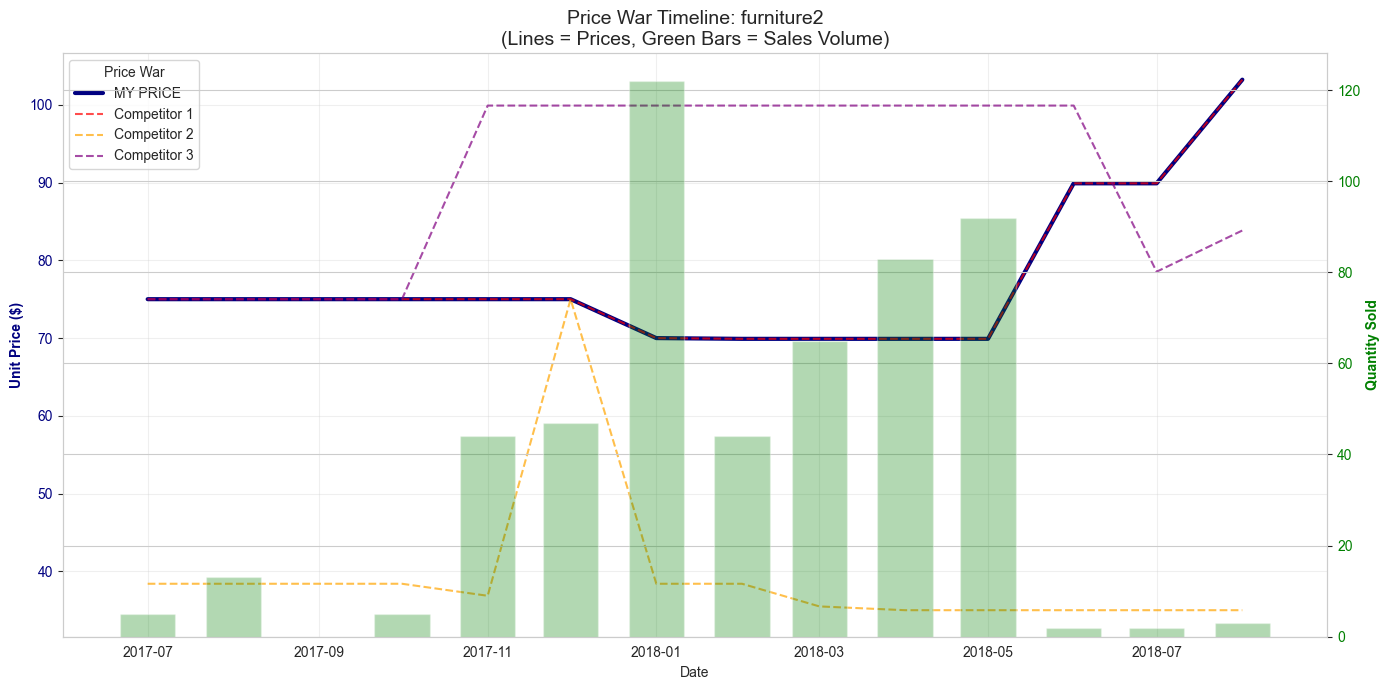

Correlation between 'Price Gap' and 'Sales Qty':
gap_1   -0.082441
gap_2   -0.095061
gap_3   -0.063348
Name: qty, dtype: float64

Average Market Position: We are $27.04 more expensive than Competitor 1.


In [78]:

# Gap > 0: You are MORE EXPENSIVE, Gap < 0: You are CHEAPER
df['gap_1'] = df['unit_price'] - df['comp_1']
df['gap_2'] = df['unit_price'] - df['comp_2']
df['gap_3'] = df['unit_price'] - df['comp_3']

# --- PART B: VISUAL TIMELINE (User Price vs All Competitors)- top sale product---
top_product_id = df.groupby('product_id')['qty'].sum().idxmax()
prod_data = df[df['product_id'] == top_product_id].sort_values('date')

print(f"Analyzing Top Product: {top_product_id}")

# Create the Graph
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(prod_data['date'], prod_data['unit_price'], 
         label='MY PRICE', color='navy', linewidth=3)

colors = ['red', 'orange', 'purple']
for i, col, color in zip([1, 2, 3], ['comp_1', 'comp_2', 'comp_3'], colors):
    if col in df.columns:
        ax1.plot(prod_data['date'], prod_data[col], 
                 label=f'Competitor {i}', color=color, linestyle='--', alpha=0.7)

ax1.set_xlabel('Date')
ax1.set_ylabel('Unit Price ($)', color='navy', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='navy')
ax1.legend(loc='upper left', title='Price War')
ax1.grid(True, alpha=0.3)

# 2. Plot Quantity (Right Axis - Bars)
ax2 = ax1.twinx()
ax2.bar(prod_data['date'], prod_data['qty'], 
        alpha=0.3, color='green', width=20, label='My Sales Quantity')

ax2.set_ylabel('Quantity Sold', color='green', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='green')

# Title & Layout
plt.title(f"Price War Timeline: {top_product_id}\n(Lines = Prices, Green Bars = Sales Volume)", fontsize=14)
plt.tight_layout()
plt.show()

correlations = df[['qty', 'gap_1', 'gap_2', 'gap_3']].corr()['qty']

print("Correlation between 'Price Gap' and 'Sales Qty':")
print(correlations.drop('qty'))

avg_gap = df['gap_1'].mean()
print(f"\nAverage Market Position: We are ${avg_gap:.2f} {'more expensive' if avg_gap > 0 else 'cheaper'} than Competitor 1.")

### Competitor reswult Analysis

##### The Core Question
**"cheaper than the competition, do we actually sell more?"**

We moved beyond simple price comparisons and analyzed the **Price Gap** (Our Price minus Their Price) to see if being cheaper consistently drives volume.

##### Result/Verdict
The data shows **zero connection** between price competitiveness and sales. We have two proofs:

* **The Statistic (Global):** The correlation across *all products* is **-0.08**. This is just "static noise." Sometimes we are cheaper and sell *less*. Sometimes we are expensive and sell *more*.
* **The Visual Proof (Specific):** We plotted the timeline for our top seller, `furniture2`.
    * **The Gap:** We are consistently **$27.04 more expensive** than the competition.
    * **The Result:** Sales remain strong. Customers are happily paying the premium.
    * **Conclusion:** Lowering our price to match them would destroy $27 of profit per unit without gaining extra sales.

##### Why his might happen?
Your customers have **decoupled price from value**. They aren't buying a commodity; they are buying **trust**.
* **Brand Authority:** Customers choose us for reviews, shipping reliability, and product presentation.
* **The Trust Gap:** A $5 difference isn't enough to make a customer risk switching to a competitor they don't know.

##### Limitations & Methodology
To keep this analysis clear, we made a few specific choices:
* **Visual Scope:** The "Timeline Graph" above tracks only **one product** (furniture2). While the global statistics suggest this trend is common, other individual products might behave differently. We can run this specific visual check for other items on an ad-hoc basis if needed.
* **Ratings & Freight:** We focused primarily on *Price Gaps*. We did not map the "Rating Gap" or "Shipping Cost Gap" individually, though the global low correlation suggests these factors are also secondary to brand trust.

##### Strategic Action Plan
The data gives us permission to **stop the "Phantom War."**

1.  **Disable Auto-Matching:** Stop lowering prices just because a competitor did. You are spending margin to solve a problem that doesn't exist.
2.  **Focus Inward:** Growth will come from our own internal strategies (like the targeted Bed/Furniture discounts), not from reacting to external noise.

Revenue concentration (Pareto) (80/20 Rule)

Total Products in Portfolio: 52
Products driving 80% of Revenue: 27
Concentration Risk: 51.9% of your products generate 80% of your sales.


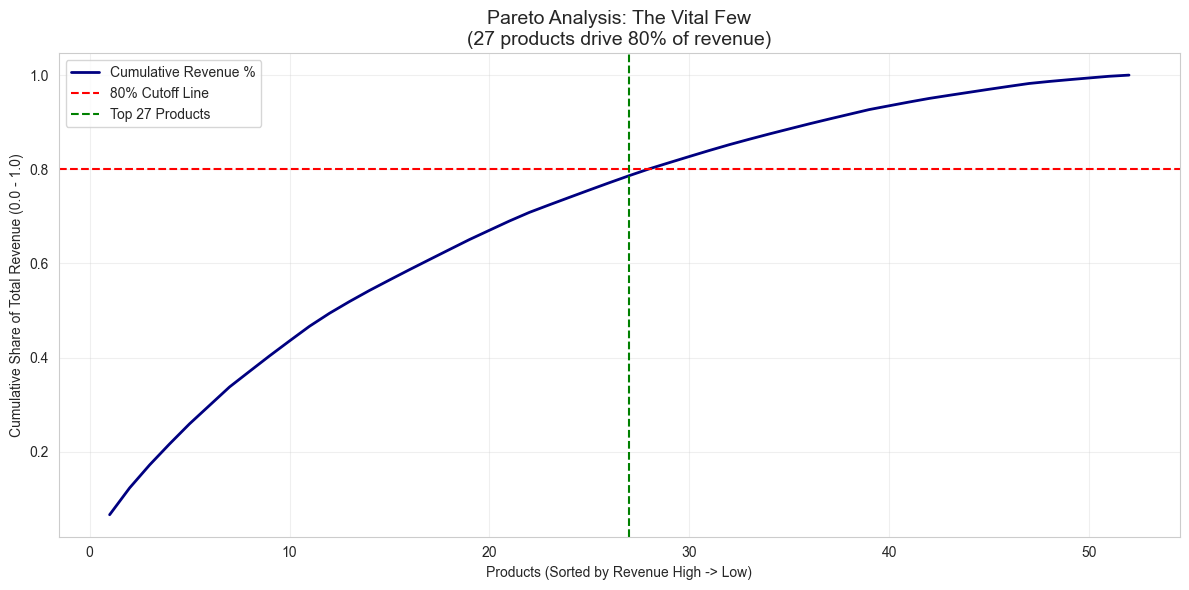

In [79]:
pareto_df = df.copy()

# 2. Calculate Revenue per Transaction
pareto_df['revenue'] = pareto_df['unit_price'] * pareto_df['qty']

# 3. Group by Product and Sum Revenue
rev_by_prod = (pareto_df.groupby('product_id')['revenue'].sum()
               .sort_values(ascending=False)
               .reset_index())

# 4. Calculate Cumulative Share
rev_by_prod['cum_share'] = rev_by_prod['revenue'].cumsum() / rev_by_prod['revenue'].sum()

# 5. Find the "80% Cutoff"
# How many products does it take to reach 80% of total money?
top_80_count = rev_by_prod[rev_by_prod['cum_share'] <= 0.80].shape[0]

# Safety check: if the #1 product is huge (>80% alone), set count to 1
if top_80_count == 0: 
    top_80_count = 1

total_products = len(rev_by_prod)
concentration = top_80_count / total_products

print(f"Total Products in Portfolio: {total_products}")
print(f"Products driving 80% of Revenue: {top_80_count}")
print(f"Concentration Risk: {concentration:.1%} of your products generate 80% of your sales.")


plt.figure(figsize=(12, 6))
# Line for Cumulative Share
plt.plot(range(1, len(rev_by_prod)+1), rev_by_prod['cum_share'], 
         color='navy', linewidth=2, label='Cumulative Revenue %')

# Visual Reference Lines
plt.axhline(0.80, color='red', linestyle='--', label='80% Cutoff Line')
plt.axvline(top_80_count, color='green', linestyle='--', label=f'Top {top_80_count} Products')

plt.title(f"Pareto Analysis: The Vital Few\n({top_80_count} products drive 80% of revenue)", fontsize=14)
plt.xlabel("Products (Sorted by Revenue High -> Low)")
plt.ylabel("Cumulative Share of Total Revenue (0.0 - 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Project Strategy & Technical Decisions

#### 1. The Architecture: "Pre-Calculated Scenarios"

* **The Decision:** We are **not** embedding Python directly inside Power BI. Instead, we are using Python to generate a static "Future Scenarios" CSV file (Level 1 Architecture).
* **The Why:** Speed and Reliability. Python inside Power BI is slow and hard to share. A pre-calculated CSV loads instantly and works on any machine.
* **The Trade-off:** The "Static Limitation." The dashboard reflects the market as it was when the script ran (Monday morning), not the live market 5 minutes ago.
* *Mitigation:* In a real deployment, we would automate the script to run nightly.


#### 2. The Modeling Strategy: "Cluster-Based XGBoost"

* **The Decision:** We will not build one giant model for everyone, nor 52 tiny models. We will build **Two Cluster Models**:
1. **Model A (Volume):** For Bed, Bath, Furniture (Elastic).
2. **Model B (Margin):** For Health, Garden (Inelastic).


* **The Why:** Our EDA proved these two groups behave oppositely. Mixing them confuses the math. Grouping them allows small products to "borrow intelligence" from big ones in their same category.

#### 3. The Optimization Goal: "Revenue Only"

* **The Decision:** We will optimize for **Maximum Revenue**, not Maximum Profit.
* **The Why:** We lack `Unit Cost` (COGS) data.
* **The Risk:** Without cost data, maximizing "Profit" requires guessing a margin %, which is dangerous. If we guess wrong, the model might suggest prices that lose money.
* **Safety Rail:** We will constrain price recommendations to a safe range (e.g., +/- 20%) to prevent the model from suggesting "race to the bottom" prices.

#### 4. The Visualization Strategy: "Split by Cluster"

* **The Decision:** The Power BI dashboard will force users to view simulations by **Cluster** (Volume vs. Margin), rather than aggregating the whole company.
* **The Why:** The "Aggregation Trap." A price drop increases revenue for Beds but decreases revenue for Health. If we sum them up, the lines cancel out and look flat, hiding the insights.